Code from the winning model (https://github.com/drivendataorg/magnet-geomagnetic-field/blob/399c123f1470c0f4de5c2a27122e9954497190ac/1st_Place/MagNet_Model_the_Geomagnetic_Field_first_place_solution.ipynb) adapted to use transformer architecture.

In [ ]:
#Extract the Data
# !unzip magNet.zip 

In [4]:
# # download and save data
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
# !unzip public.zip
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
# !unzip private.zip
# !mkdir -p data
# !mv public data
# !mv private data

--2021-11-14 04:24:41--  https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
Resolving ngdc.noaa.gov (ngdc.noaa.gov)... 140.172.190.1
Connecting to ngdc.noaa.gov (ngdc.noaa.gov)|140.172.190.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287399979 (274M) [application/zip]
Saving to: ‘public.zip.1’

public.zip.1        100%[===================>] 274.09M  5.13MB/s    in 51s     

2021-11-14 04:25:32 (5.35 MB/s) - ‘public.zip.1’ saved [287399979/287399979]

Archive:  public.zip
   creating: public/
  inflating: public/sunspots.csv     
  inflating: public/satellite_positions.csv  
  inflating: public/dst_labels.csv   
  inflating: public/solar_wind.csv   
--2021-11-14 04:25:43--  https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
Resolving ngdc.noaa.gov (ngdc.noaa.gov)... 140.172.190.1
Connecting to ngdc.noaa.gov (ngdc.noaa.gov)|140.172.190.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112217628 (107M) [application/

In [5]:
!ls

benchmark.ipynb
benchmark.py
data
explore_v1.py
hybrid_model.ipynb
hybrid_model_lstm2.ipynb
hybrid_model_lstm3.ipynb
hybrid_model_lstm.ipynb
hybrid_model_no_freeze.ipynb
hybrid_model.py
including_old_data.ipynb
including_old_data_lstm.ipynb
MagNet_Model_the_Geomagnetic_Field_first_place_solution-Copy1.ipynb
MagNet_Model_the_Geomagnetic_Field_first_place_solution_transformer_lstm.ipynb
make_test_data.py
model2
model_definitions.py
old_data_test.py
plotting.py
predict.py
preprocessing.py
private
private.zip
private.zip.1
process_old_data.py
public
public.zip
public.zip.1
__pycache__
Readme.md
trained_models
train_hybrid.py
train_on_all_data.py
train.py
untitled.txt
v2_MagNet_Model_the_Geomagnetic_Field_first_place_solution_attention_head.ipynb
v3_MagNet_Model_the_Geomagnetic_Field_first_place_solution_conv_layer.ipynb


In [6]:
#Update sklearn Library
!pip install -U scikit-learn

In [7]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline

In [8]:
# read the data
DATA_PATH = Path("data/public")
dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
#satellite_positions = pd.read_csv(DATA_PATH / "satellite_positions.csv")



In [9]:
solar_wind.head()

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,ac
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,ac
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,ac
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,ac
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,ac


In [10]:
#Data indexing according to the timestamps
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)


sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)


solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)


In [11]:
print("Dst shape: ", dst.shape)
dst.head()

Dst shape:  (139872, 1)


dst
period  timedelta           
train_a 0 days 00:00:00   -7
        0 days 01:00:00  -10
        0 days 02:00:00  -10
        0 days 03:00:00   -6
        0 days 04:00:00   -2

In [12]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

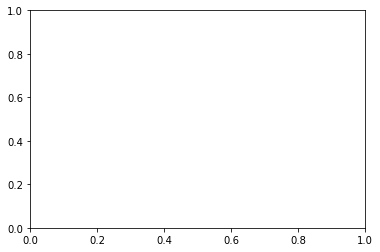

In [13]:
fig, ax = plt.subplots()
colors = ["r", "b", "y"]
for i, period in enumerate(dst.groupby("period")):
    period_name, df = period
    

In [14]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [15]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4

In [16]:
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [17]:
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

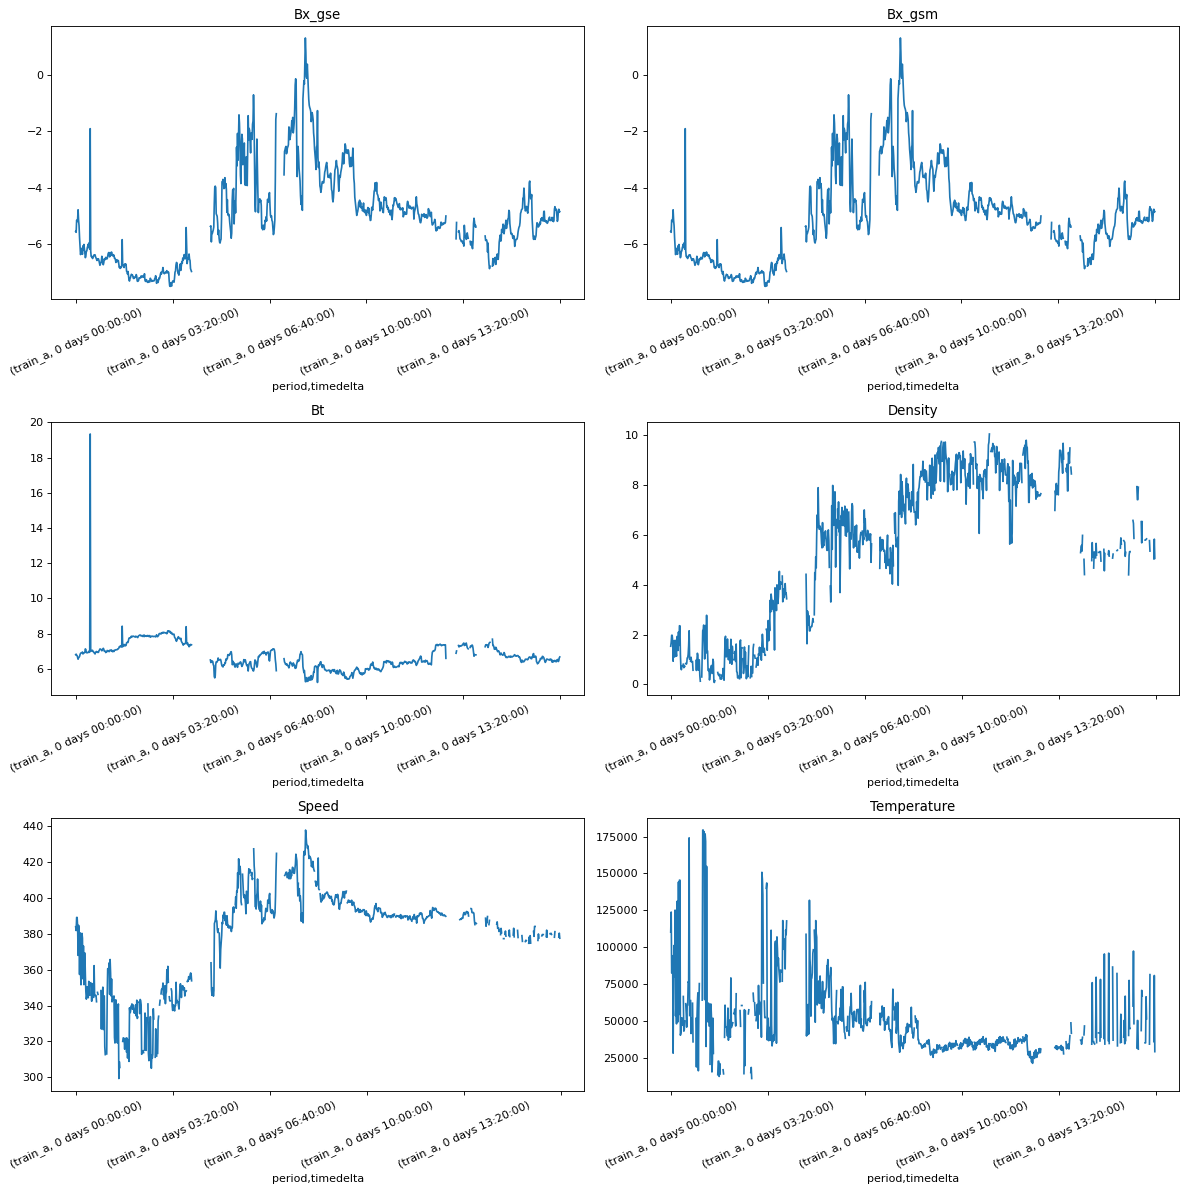

In [18]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [19]:
solar_wind.reset_index()


,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,ac
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,ac
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,ac
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,ac
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,ac
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8392315,train_c,2435 days 23:55:00,-1.18,2.00,-3.92,-59.28,120.51,-1.17,2.98,-3.23,-45.24,111.48,4.56,4.64,348.73,23368.0,ac
8392316,train_c,2435 days 23:56:00,-1.34,2.12,-3.83,-56.78,122.23,-1.33,3.08,-3.12,-42.95,113.45,4.58,4.27,346.36,26497.0,ac
8392317,train_c,2435 days 23:57:00,-1.62,2.33,-3.63,-51.98,124.76,-1.61,3.22,-2.87,-38.57,116.58,4.61,3.95,344.12,27050.0,ac
8392318,train_c,2435 days 23:58:00,-2.27,2.48,-3.22,-43.81,132.50,-2.26,3.25,-2.44,-31.61,124.81,4.65,2.81,338.52,33257.0,ac


In [20]:
solar_wind.isna().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

In [21]:
sunspots

smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4
...                         ...
train_c 2283 days          26.4
        2314 days          29.5
        2344 days          34.5
        2375 days          39.1
        2405 days          42.5

[192 rows x 1 columns]

In [22]:
solar_wind.join(sunspots).join(dst)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  \
period  timedelta                                                        
train_a 0 days 00:00:00      -5.55    3.00    1.25      11.09   153.37   
        0 days 00:01:00      -5.58    3.16    1.17      10.10   151.91   
        0 days 00:02:00      -5.15    3.66    0.85       7.87   146.04   
        0 days 00:03:00      -5.20    3.68    0.68       6.17   146.17   
        0 days 00:04:00      -5.12    3.68    0.49       4.62   145.72   
...                            ...     ...     ...        ...      ...   
train_c 2435 days 23:55:00   -1.18    2.00   -3.92     -59.28   120.51   
        2435 days 23:56:00   -1.34    2.12   -3.83     -56.78   122.23   
        2435 days 23:57:00   -1.62    2.33   -3.63     -51.98   124.76   
        2435 days 23:58:00   -2.27    2.48   -3.22     -43.81   132.50   
        2435 days 23:59:00   -2.15    2.41   -3.30     -45.55   131.76   

                            bx_gsm  by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  \
period  timedelta                                                              
train_a 0 days 00:00:00      -5.55    3.00    1.25      11.09   153.37  6.80   
        0 days 00:01:00      -5.58    3.16    1.17      10.10   151.91  6.83   
        0 days 00:02:00      -5.15    3.66    0.85       7.87   146.04  6.77   
        0 days 00:03:00      -5.20    3.68    0.68       6.17   146.17  6.74   
        0 days 00:04:00      -5.12    3.68    0.49       4.62   145.72  6.65   
...                            ...     ...     ...        ...      ...   ...   
train_c 2435 days 23:55:00   -1.17    2.98   -3.23     -45.24   111.48  4.56   
        2435 days 23:56:00   -1.33    3.08   -3.12     -42.95   113.45  4.58   
        2435 days 23:57:00   -1.61    3.22   -2.87     -38.57   116.58  4.61   
        2435 days 23:58:00   -2.26    3.25   -2.44     -31.61   124.81  4.65   
        2435 days 23:59:00   -2.15    3.21   -2.53     -33.21   123.75  4.62   

                            density   speed  temperature source  smoothed_ssn  \
period  timedelta                                                               
train_a 0 days 00:00:00        1.53  383.92     110237.0     ac          65.4   
        0 days 00:01:00        1.69  381.79     123825.0     ac           NaN   
        0 days 00:02:00        1.97  389.11      82548.0     ac           NaN   
        0 days 00:03:00        1.97  389.11      82548.0     ac           NaN   
        0 days 00:04:00        1.77  384.26      94269.0     ac           NaN   
...                             ...     ...          ...    ...           ...   
train_c 2435 days 23:55:00     4.64  348.73      23368.0     ac           NaN   
        2435 days 23:56:00     4.27  346.36      26497.0     ac           NaN   
        2435 days 23:57:00     3.95  344.12      27050.0     ac           NaN   
        2435 days 23:58:00     2.81  338.52      33257.0     ac           NaN   
        2435 days 23:59:00     2.30  342.31      32267.0     ac           NaN   

                            dst  
period  timedelta                
train_a 0 days 00:00:00    -7.0  
        0 days 00:01:00     NaN  
        0 days 00:02:00     NaN  
        0 days 00:03:00     NaN  
        0 days 00:04:00     NaN  
...                         ...  
train_c 2435 days 23:55:00  NaN  
        2435 days 23:56:00  NaN  
        2435 days 23:57:00  NaN  
        2435 days 23:58:00  NaN  
        2435 days 23:59:00  NaN  

[8392320 rows x 17 columns]

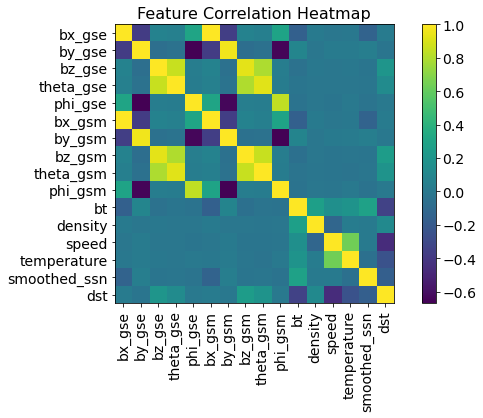

In [23]:
corr = solar_wind.join(sunspots).join(dst).fillna(method="pad").corr()
corr = solar_wind.join(sunspots).join(dst).fillna(method="bfill").corr()
plt.figure(figsize=(10, 5))
plt.matshow(corr, fignum=1)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)


cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

In [24]:
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow.random import set_seed
seed(2020)
set_seed(2021)

In [25]:
import numpy as np
from sklearn.preprocessing import StandardScaler,power_transform
from sklearn.impute import  SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PowerTransformer
# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gsm",
    "by_gsm",
    "bz_gsm",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    
    + ["smoothed_ssn"] 
)


def impute_features(feature_df, imp = None):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # missing solar wind values imputation using most-frequent strategy
    feature_df=feature_df.reset_index()
    cols = feature_df.columns[2:]
    if imp == None:
      imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
      imp.fit(feature_df[cols])
    temp = imp.transform(feature_df[cols])
    feature_df[cols] = temp
    feature_df.timedelta = pd.to_timedelta(feature_df.timedelta)
    feature_df.set_index(["period", "timedelta"], inplace=True)
    return feature_df , imp


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None ,subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]
    # aggregate solar wind data and join with sunspots
    
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed, imp = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler, imp

In [26]:

features, scaler, imputer = preprocess_features(solar_wind, sunspots , subset=SOLAR_WIND_FEATURES)

print(features.shape)
features.head()

(139872, 29)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         ...  bz_gsm_std  phi_gsm_mean  phi_gsm_std  \
period  timedelta        ...                                          
train_a 0 days 00:00:00  ...   -0.645095     -0.368627    -0.720724   
        0 days 01:00:00  ...   -0.511040     -0.255717    -0.752218   
        0 days 02:00:00  ...   -0.870482     -0.254145    -0.868503   
        0 days 03:00:00  ...   -0.282789     -0.049648    -0.638287   
        0 days 04:00:00  ...   -0.471111     -0.238606    -0.387514   

                         theta_gsm_mean  theta_gsm_std  speed_mean  speed_std  \
period  timedelta                                                               
train_a 0 days 00:00:00        0.247927      -1.144826   -0.738546   0.862524   
        0 days 01:00:00        0.358697      -1.052803   -0.986904   0.995063   
        0 days 02:00:00        0.576426      -1.392092   -1.013548   0.554085   
        0 days 03:00:00        0.466099      -0.902858   -0.826469  -0.211185   
        0 days 04:00:00        0.442384      -0.906160   -0.601238   1.016033   

                         density_mean  density_std  smoothed_ssn  
period  timedelta                                                 
train_a 0 days 00:00:00     -0.775827    -0.205724      0.139444  
        0 days 01:00:00     -0.861692    -0.058215      0.139444  
        0 days 02:00:00     -0.846222    -0.220012      0.139444  
        0 days 03:00:00     -0.404306     0.218373      0.139444  
        0 days 04:00:00     -0.371487     0.097253      0.139444  

[5 rows x 29 columns]

In [27]:
print(features.shape)
features.head()

(139872, 29)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         ...  bz_gsm_std  phi_gsm_mean  phi_gsm_std  \
period  timedelta        ...                                          
train_a 0 days 00:00:00  ...   -0.645095     -0.368627    -0.720724   
        0 days 01:00:00  ...   -0.511040     -0.255717    -0.752218   
        0 days 02:00:00  ...   -0.870482     -0.254145    -0.868503   
        0 days 03:00:00  ...   -0.282789     -0.049648    -0.638287   
        0 days 04:00:00  ...   -0.471111     -0.238606    -0.387514   

                         theta_gsm_mean  theta_gsm_std  speed_mean  speed_std  \
period  timedelta                                                               
train_a 0 days 00:00:00        0.247927      -1.144826   -0.738546   0.862524   
        0 days 01:00:00        0.358697      -1.052803   -0.986904   0.995063   
        0 days 02:00:00        0.576426      -1.392092   -1.013548   0.554085   
        0 days 03:00:00        0.466099      -0.902858   -0.826469  -0.211185   
        0 days 04:00:00        0.442384      -0.906160   -0.601238   1.016033   

                         density_mean  density_std  smoothed_ssn  
period  timedelta                                                 
train_a 0 days 00:00:00     -0.775827    -0.205724      0.139444  
        0 days 01:00:00     -0.861692    -0.058215      0.139444  
        0 days 02:00:00     -0.846222    -0.220012      0.139444  
        0 days 03:00:00     -0.404306     0.218373      0.139444  
        0 days 04:00:00     -0.371487     0.097253      0.139444  

[5 rows x 29 columns]

In [28]:
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

In [29]:
# Note from DrivenData Reviewer: As written, the labels created here
# are behind by one hour, i.e. the column labeled `t0` is actually `t-1`
# and the column labeled `t1` is actually `t0`
# To correct, the below function can be replaced with:
def process_labels(dst):
    y = dst.copy()
    y["t0"] = y.groupby("period").dst.shift(-1)
    y["t1"] = y.groupby("period").dst.shift(-2)
    return y[YCOLS]
YCOLS = ["t0", "t1"]
# def process_labels(dst):
#     y = dst.copy()
#     y["t1"] = y.groupby("period").dst.shift(-1)
#     y.columns = YCOLS
#     return y


labels = process_labels(dst)


labels.head()

t0    t1
period  timedelta                  
train_a 0 days 00:00:00 -10.0 -10.0
        0 days 01:00:00 -10.0  -6.0
        0 days 02:00:00  -6.0  -2.0
        0 days 03:00:00  -2.0   3.0
        0 days 04:00:00   3.0   5.0

In [30]:
data = labels.join(features)

data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -2.0   3.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00   3.0   5.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  ...  bz_gsm_std  \
period  timedelta                                 ...               
train_a 0 days 00:00:00     0.419516    0.031658  ...   -0.645095   
        0 days 01:00:00     0.179257   -0.272971  ...   -0.511040   
        0 days 02:00:00     0.183266   -0.822786  ...   -0.870482   
        0 days 03:00:00    -0.378111    0.341156  ...   -0.282789   
        0 days 04:00:00     0.072745    1.023019  ...   -0.471111   

                         phi_gsm_mean  phi_gsm_std  theta_gsm_mean  \
period  timedelta                                                    
train_a 0 days 00:00:00     -0.368627    -0.720724        0.247927   
        0 days 01:00:00     -0.255717    -0.752218        0.358697   
        0 days 02:00:00     -0.254145    -0.868503        0.576426   
        0 days 03:00:00     -0.049648    -0.638287        0.466099   
        0 days 04:00:00     -0.238606    -0.387514        0.442384   

                         theta_gsm_std  speed_mean  speed_std  density_mean  \
period  timedelta                                                             
train_a 0 days 00:00:00      -1.144826   -0.738546   0.862524     -0.775827   
        0 days 01:00:00      -1.052803   -0.986904   0.995063     -0.861692   
        0 days 02:00:00      -1.392092   -1.013548   0.554085     -0.846222   
        0 days 03:00:00      -0.902858   -0.826469  -0.211185     -0.404306   
        0 days 04:00:00      -0.906160   -0.601238   1.016033     -0.371487   

                         density_std  smoothed_ssn  
period  timedelta                                   
train_a 0 days 00:00:00    -0.205724      0.139444  
        0 days 01:00:00    -0.058215      0.139444  
        0 days 02:00:00    -0.220012      0.139444  
        0 days 03:00:00     0.218373      0.139444  
        0 days 04:00:00     0.097253      0.139444  

[5 rows x 31 columns]

In [31]:
labels

t0    t1
period  timedelta                     
train_a 0 days 00:00:00    -10.0 -10.0
        0 days 01:00:00    -10.0  -6.0
        0 days 02:00:00     -6.0  -2.0
        0 days 03:00:00     -2.0   3.0
        0 days 04:00:00      3.0   5.0
...                          ...   ...
train_c 2435 days 19:00:00 -14.0 -14.0
        2435 days 20:00:00 -14.0 -15.0
        2435 days 21:00:00 -15.0 -14.0
        2435 days 22:00:00 -14.0   NaN
        2435 days 23:00:00   NaN   NaN

[139872 rows x 2 columns]

In [32]:
# Note from DrivenData Reviewer: Here, the validation set is taken from
# the head of the same data as the test set, and therefore is a complete
# subset of the test set. To create a validation set that has no intersection
# with the test set, the `val` assignment line should be replaced with:
# `val = interim.groupby("period").head(val_per_period)`
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the first `test_per_period` rows from each period to test
    test = data.groupby("period").head(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the first `val_per_period` rows from each period to validation
    val = data.groupby("period").head(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=10_000)

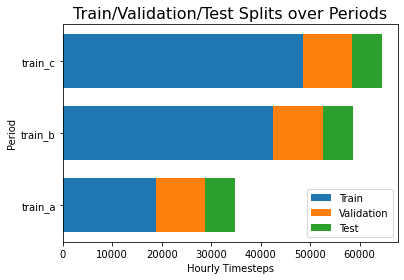

In [33]:
ind = [0, 1, 2]
names = ["train_a", "train_b", "train_c"]
width = 0.75
train_cnts = [len(df) for _, df in train.groupby("period")]
val_cnts = [len(df) for _, df in val.groupby("period")]
test_cnts = [len(df) for _, df in test.groupby("period")]

p1 = plt.barh(ind, train_cnts, width)
p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())

plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Train", "Validation", "Test"])

In [34]:
print(train.shape)
train.head()

(109872, 31)


t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                             
train_a 416 days 16:00:00 -12.0 -13.0 -0.831798 -0.901734         -0.592409   
        416 days 17:00:00 -13.0  -7.0 -0.831798 -0.901734         -0.605638   
        416 days 18:00:00  -7.0  -4.0 -0.020521  1.727834         -0.642814   
        416 days 19:00:00  -4.0  -8.0 -0.939196  0.973049         -0.395096   
        416 days 20:00:00  -8.0 -13.0 -0.531169  1.477958         -0.410307   

                           temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                     
train_a 416 days 16:00:00        -0.566945    -0.760538   -1.200652   
        416 days 17:00:00        -0.499055    -0.760538   -1.200652   
        416 days 18:00:00        -0.499773    -1.022439   -0.361149   
        416 days 19:00:00        -0.541895    -0.081450   -0.084835   
        416 days 20:00:00        -0.434334    -0.116751    0.001736   

                           by_gse_mean  by_gse_std  ...  bz_gsm_std  \
period  timedelta                                   ...               
train_a 416 days 16:00:00    -0.667159   -1.027592  ...   -0.757869   
        416 days 17:00:00    -0.667159   -1.027592  ...   -0.757869   
        416 days 18:00:00     0.106835   -0.810356  ...   -0.172107   
        416 days 19:00:00    -0.569656    0.222663  ...   -0.389586   
        416 days 20:00:00    -0.510428    0.372935  ...    1.493190   

                           phi_gsm_mean  phi_gsm_std  theta_gsm_mean  \
period  timedelta                                                      
train_a 416 days 16:00:00     -0.822717    -0.740843       -0.256974   
        416 days 17:00:00     -0.822717    -0.740843       -0.256974   
        416 days 18:00:00      0.021010    -0.830126        1.324174   
        416 days 19:00:00      0.389716     0.359278       -0.858545   
        416 days 20:00:00      0.500815    -0.164880       -0.083241   

                           theta_gsm_std  speed_mean  speed_std  density_mean  \
period  timedelta                                                               
train_a 416 days 16:00:00      -1.507547   -0.473291  -0.318274      1.388216   
        416 days 17:00:00      -1.507547   -0.505916  -0.421718      1.140001   
        416 days 18:00:00      -1.074368   -0.527609  -0.704190      1.065851   
        416 days 19:00:00       1.025138   -0.620047  -0.178420      0.836517   
        416 days 20:00:00       3.225089   -0.572992  -0.372134      0.567356   

                           density_std  smoothed_ssn  
period  timedelta                                     
train_a 416 days 16:00:00     0.916469      1.277265  
        416 days 17:00:00     0.348513      1.277265  
        416 days 18:00:00     0.379813      1.277265  
        416 days 19:00:00     0.026178      1.277265  
        416 days 20:00:00     0.359572      1.277265  

[5 rows x 31 columns]

In [35]:
print(test.shape)
test.head()

(18000, 31)


t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -2.0   3.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00   3.0   5.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  ...  bz_gsm_std  \
period  timedelta                                 ...               
train_a 0 days 00:00:00     0.419516    0.031658  ...   -0.645095   
        0 days 01:00:00     0.179257   -0.272971  ...   -0.511040   
        0 days 02:00:00     0.183266   -0.822786  ...   -0.870482   
        0 days 03:00:00    -0.378111    0.341156  ...   -0.282789   
        0 days 04:00:00     0.072745    1.023019  ...   -0.471111   

                         phi_gsm_mean  phi_gsm_std  theta_gsm_mean  \
period  timedelta                                                    
train_a 0 days 00:00:00     -0.368627    -0.720724        0.247927   
        0 days 01:00:00     -0.255717    -0.752218        0.358697   
        0 days 02:00:00     -0.254145    -0.868503        0.576426   
        0 days 03:00:00     -0.049648    -0.638287        0.466099   
        0 days 04:00:00     -0.238606    -0.387514        0.442384   

                         theta_gsm_std  speed_mean  speed_std  density_mean  \
period  timedelta                                                             
train_a 0 days 00:00:00      -1.144826   -0.738546   0.862524     -0.775827   
        0 days 01:00:00      -1.052803   -0.986904   0.995063     -0.861692   
        0 days 02:00:00      -1.392092   -1.013548   0.554085     -0.846222   
        0 days 03:00:00      -0.902858   -0.826469  -0.211185     -0.404306   
        0 days 04:00:00      -0.906160   -0.601238   1.016033     -0.371487   

                         density_std  smoothed_ssn  
period  timedelta                                   
train_a 0 days 00:00:00    -0.205724      0.139444  
        0 days 01:00:00    -0.058215      0.139444  
        0 days 02:00:00    -0.220012      0.139444  
        0 days 03:00:00     0.218373      0.139444  
        0 days 04:00:00     0.097253      0.139444  

[5 rows x 31 columns]

In [36]:
print(val.shape)
val.head()

(30000, 31)


t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -2.0   3.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00   3.0   5.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  ...  bz_gsm_std  \
period  timedelta                                 ...               
train_a 0 days 00:00:00     0.419516    0.031658  ...   -0.645095   
        0 days 01:00:00     0.179257   -0.272971  ...   -0.511040   
        0 days 02:00:00     0.183266   -0.822786  ...   -0.870482   
        0 days 03:00:00    -0.378111    0.341156  ...   -0.282789   
        0 days 04:00:00     0.072745    1.023019  ...   -0.471111   

                         phi_gsm_mean  phi_gsm_std  theta_gsm_mean  \
period  timedelta                                                    
train_a 0 days 00:00:00     -0.368627    -0.720724        0.247927   
        0 days 01:00:00     -0.255717    -0.752218        0.358697   
        0 days 02:00:00     -0.254145    -0.868503        0.576426   
        0 days 03:00:00     -0.049648    -0.638287        0.466099   
        0 days 04:00:00     -0.238606    -0.387514        0.442384   

                         theta_gsm_std  speed_mean  speed_std  density_mean  \
period  timedelta                                                             
train_a 0 days 00:00:00      -1.144826   -0.738546   0.862524     -0.775827   
        0 days 01:00:00      -1.052803   -0.986904   0.995063     -0.861692   
        0 days 02:00:00      -1.392092   -1.013548   0.554085     -0.846222   
        0 days 03:00:00      -0.902858   -0.826469  -0.211185     -0.404306   
        0 days 04:00:00      -0.906160   -0.601238   1.016033     -0.371487   

                         density_std  smoothed_ssn  
period  timedelta                                   
train_a 0 days 00:00:00    -0.205724      0.139444  
        0 days 01:00:00    -0.058215      0.139444  
        0 days 02:00:00    -0.220012      0.139444  
        0 days 03:00:00     0.218373      0.139444  
        0 days 04:00:00     0.097253      0.139444  

[5 rows x 31 columns]

In [37]:
import tensorflow as tf


data_config = {
    "timesteps": 128,
    "batch_size": 128,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset

train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 854
Number of val batches: 231


In [38]:
import tensorflow as tf

In [39]:
from tensorflow.keras.layers import Dense, LSTM,GRU, Bidirectional, Dropout, Embedding, Input, Flatten
from tensorflow.keras.models import Sequential
import keras

In [85]:
from tensorflow.keras.layers import Dense, LSTM,GRU, Bidirectional, Dropout, GlobalAveragePooling1D,Input,Concatenate,Flatten,Embedding,Reshape,Conv1D,TimeDistributed,BatchNormalization,GaussianNoise
from tensorflow.keras.models import Sequential

# define our model
model_config = {"n_epochs": 30, "n_neurons": 64 , "dropout": 0.0, "stateful": False}

# based on example here:
# https://keras.io/examples/timeseries/timeseries_transformer_classification/

input1 = Input(shape=( data_config["timesteps"], len(XCOLS)), name='x1')
timesteps = (tf.keras.layers.Reshape((128, 1))(tf.ones_like(input1)[:, :, 1] * tf.expand_dims(tf.range(0, 128, delta=1, dtype=float), axis=0)) -64 )/ 128
ext_inputs = tf.keras.layers.Concatenate()([input1, timesteps])

def transformer_encoder(
    inputs: tf.Tensor, head_size: int, num_heads: int, ff_dim: int, dropout: float
) -> tf.Tensor:
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout, output_shape=ff_dim,
    )(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1)(x)
    return x + res

num_transformer_blocks = 6  # how many consecutive transformer layers
head_size = 256  # channels in the attention head
#inputs = tf.keras.Input((24 * 7, 7))
num_heads = 2
ff_dim = 256
dropout = 0.4
mlp_units = [128, 64]
mlp_dropout = 0.4
x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, strides=1)(ext_inputs)
for _ in range(num_transformer_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
for dim in mlp_units:
    x = tf.keras.layers.Dense(dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(mlp_dropout)(x)
dense = tf.keras.layers.Dense(2)(tf.keras.layers.Flatten()(x))
#output = tf.keras.layers.Dense(1)(tf.keras.layers.Flatten()(out_conv))
#model = tf.keras.Model(inputs, output)



model = keras.models.Model(inputs=input1, outputs=dense)
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(0.0001),
)

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x1 (InputLayer)                 [(None, 128, 29)]    0                                            
__________________________________________________________________________________________________
tf.ones_like_2 (TFOpLambda)     (None, 128, 29)      0           x1[0][0]                         
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 128)          0           tf.ones_like_2[0][0]             
__________________________________________________________________________________________________
tf.math.multiply_2 (TFOpLambda) (None, 128)          0           tf.__operators__.getitem_2[0][0] 
___________________________________________________________________________________________

In [86]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model2.h5', save_best_only=True, monitor='val_loss', mode='min')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",factor=0.3, patience=4, min_lr=1e-10, mode='min')
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    callbacks=[checkpoint, lr_reducer],
    shuffle=False,
    validation_data=val_ds,
)

Epoch 1/30
854/854 [==============================] - 100s 110ms/step - loss: 457.3340 - val_loss: 296.3427
Epoch 2/30
854/854 [==============================] - 94s 110ms/step - loss: 289.1394 - val_loss: 222.8671
Epoch 3/30
854/854 [==============================] - 94s 110ms/step - loss: 214.1402 - val_loss: 212.5065
Epoch 4/30
854/854 [==============================] - 94s 110ms/step - loss: 187.7569 - val_loss: 174.0926
Epoch 5/30
854/854 [==============================] - 94s 110ms/step - loss: 162.4765 - val_loss: 172.5396
Epoch 6/30
854/854 [==============================] - 94s 110ms/step - loss: 150.0933 - val_loss: 166.8752
Epoch 7/30
854/854 [==============================] - 94s 110ms/step - loss: 140.8533 - val_loss: 168.0032
Epoch 8/30
854/854 [==============================] - 94s 110ms/step - loss: 130.7867 - val_loss: 163.3528
Epoch 9/30
854/854 [==============================] - 94s 110ms/step - loss: 125.3236 - val_loss: 158.6368
Epoch 10/30
854/854 [===============

In [87]:
model = keras.models.load_model("model2.h5")

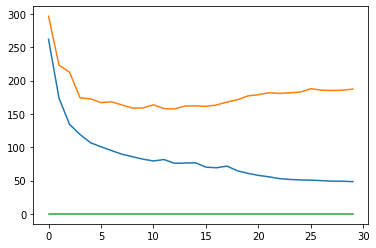

In [88]:
for name, values in history.history.items():
    plt.plot(values)

In [89]:
DATA_PATH = Path("data/private")
dst_private = pd.read_csv(DATA_PATH / "dst_labels.csv")
sunspots_private = pd.read_csv(DATA_PATH / "sunspots.csv")
solar_wind_private = pd.read_csv(DATA_PATH / "solar_wind.csv")

dst_private.timedelta = pd.to_timedelta(dst_private.timedelta)
dst_private.set_index(["period", "timedelta"], inplace=True)
sunspots_private.timedelta = pd.to_timedelta(sunspots_private.timedelta)
sunspots_private.set_index(["period", "timedelta"], inplace=True)
solar_wind_private.timedelta = pd.to_timedelta(solar_wind_private.timedelta)
solar_wind_private.set_index(["period", "timedelta"], inplace=True)

solar_wind_private.reset_index()
solar_wind_private.join(sunspots_private).join(dst_private)
features_private, scaler, imputer = preprocess_features(solar_wind_private, sunspots_private , subset=SOLAR_WIND_FEATURES, scaler=scaler)
private_labels = process_labels(dst_private)
private_data = private_labels.join(features_private)

In [90]:
private_test_ds = timeseries_dataset_from_df(private_data, data_config["batch_size"])

In [91]:
mse = model.evaluate(private_test_ds)
print(f"Private test RMSE: {mse**.5:.2f}")

458/458 [==============================] - 20s 40ms/step - loss: 166.8162
Private test RMSE: 12.92


In [92]:
preds = model.predict(private_test_ds)

# iterate through periods
dst_test_arr = []
for _, period_df in private_data.groupby("period"):
    # realign features and labels so that first sequence of 32 is aligned with the 33rd target
    outputs = period_df[YCOLS][128:]
    dst_test_arr.append(outputs.iloc[:-127, :])

dst_test = pd.concat(dst_test_arr, axis=0)
dst_test.columns = ["dst", "dst_t_plus_1"]
dst_test.reset_index(inplace=True)
dst_test[["prediction_t", "prediction_t_plus_1"]] = preds

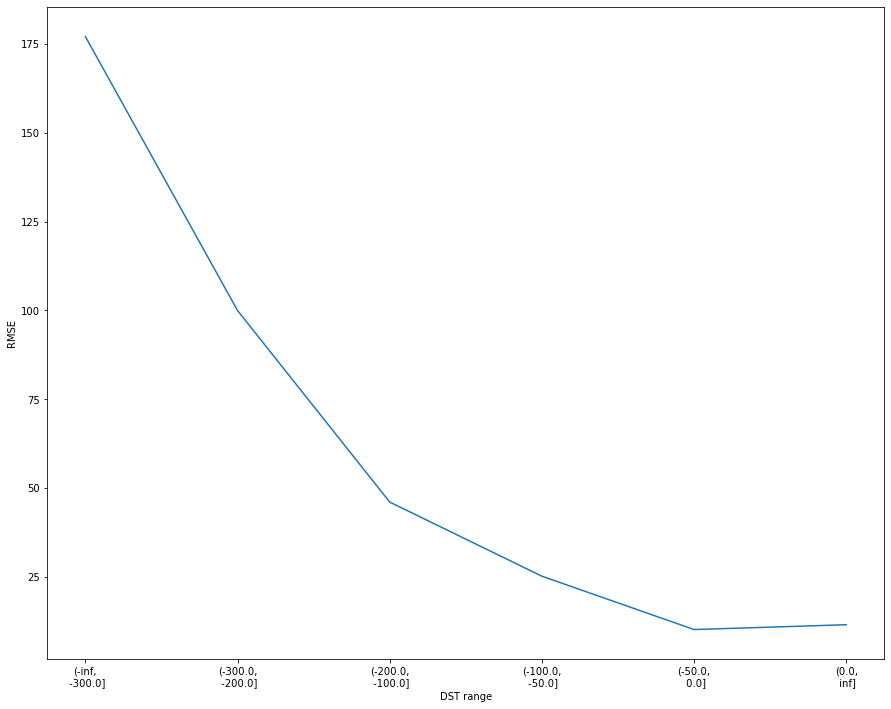

In [93]:
# plot errors in different DST ranges
from plotting import plot_binned_RMSE
plt.figure(figsize=(15, 12))
bins = [-np.inf, -300, -200, -100, -50, 0, np.inf]
plot_binned_RMSE(dst_test[ "dst"].values, dst_test["prediction_t"].values, bins)

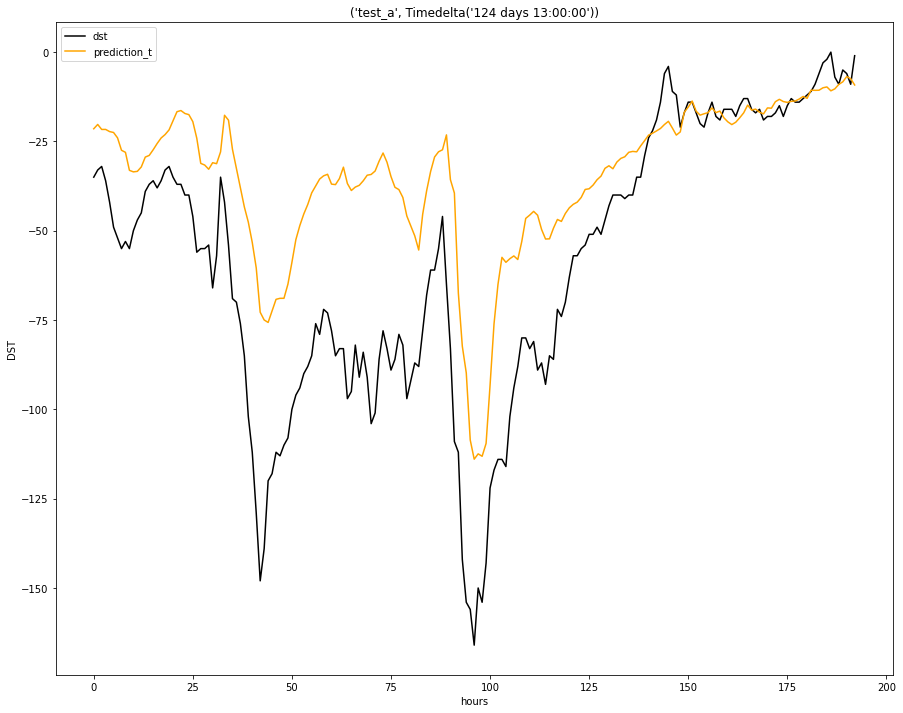

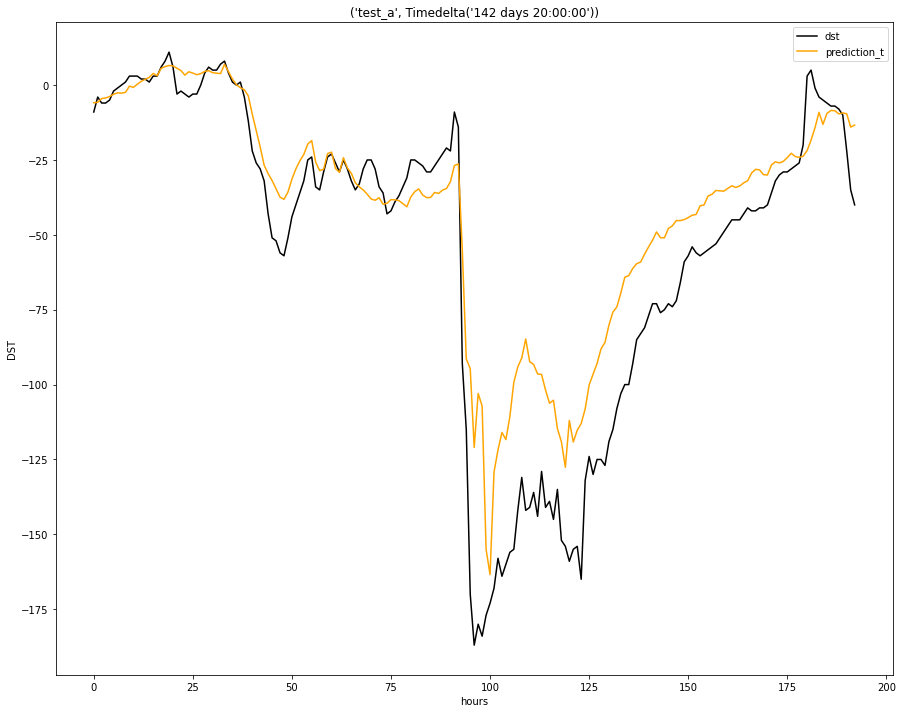

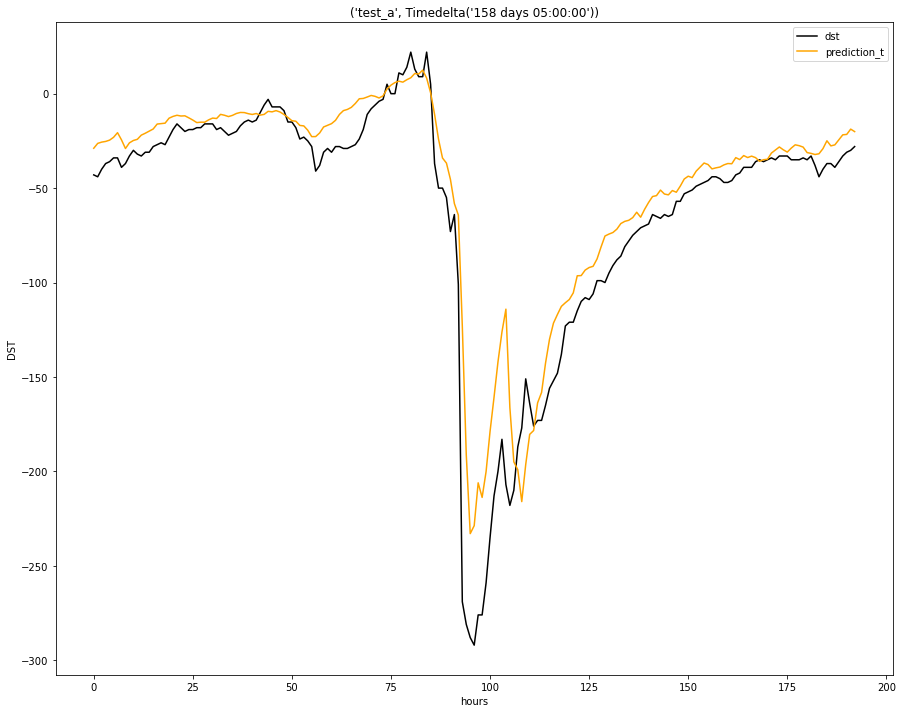

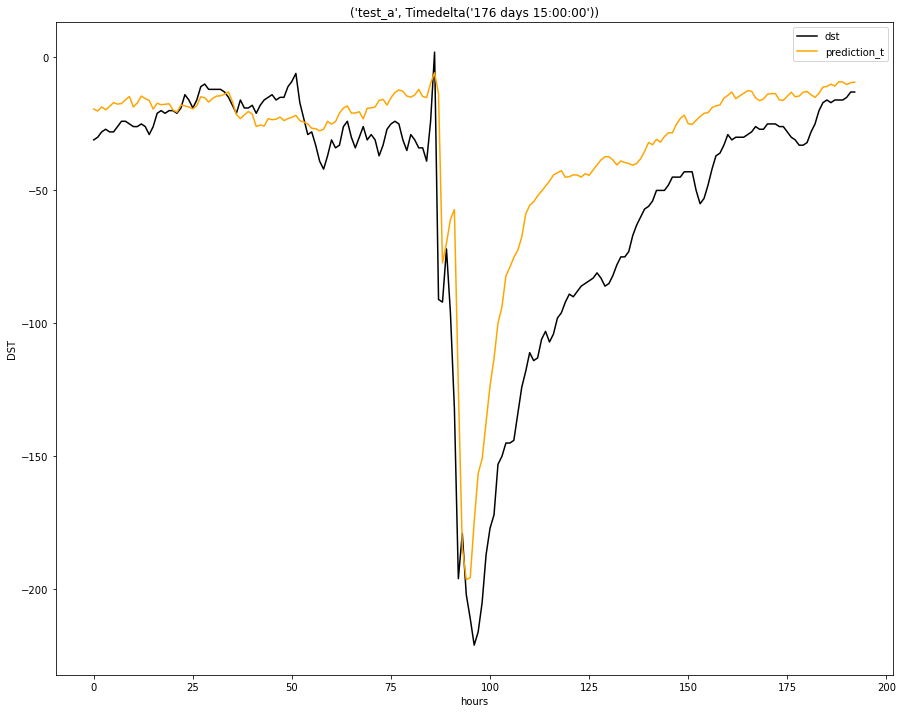

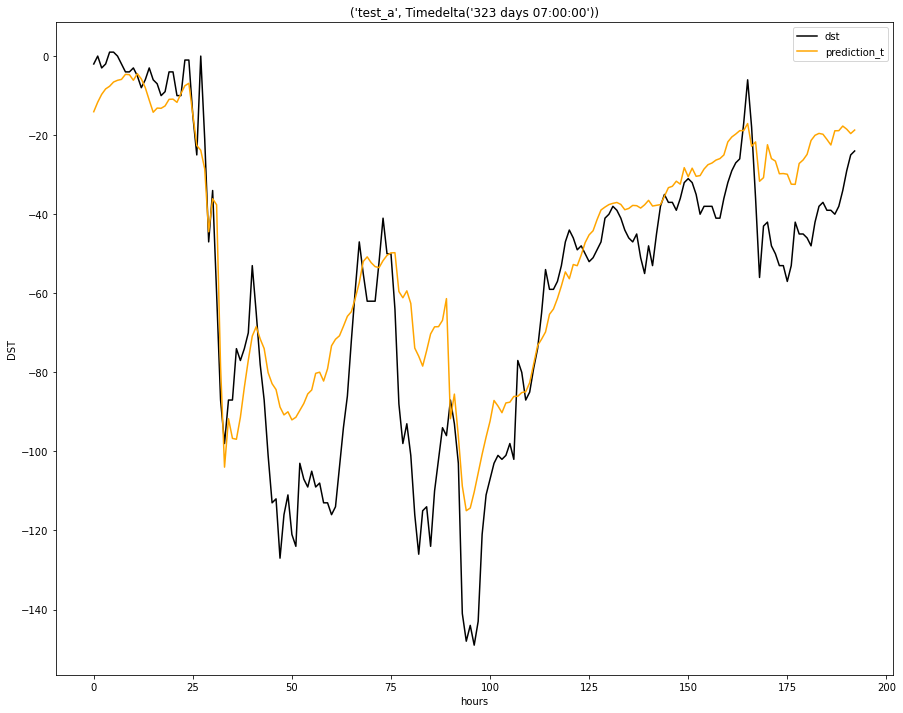

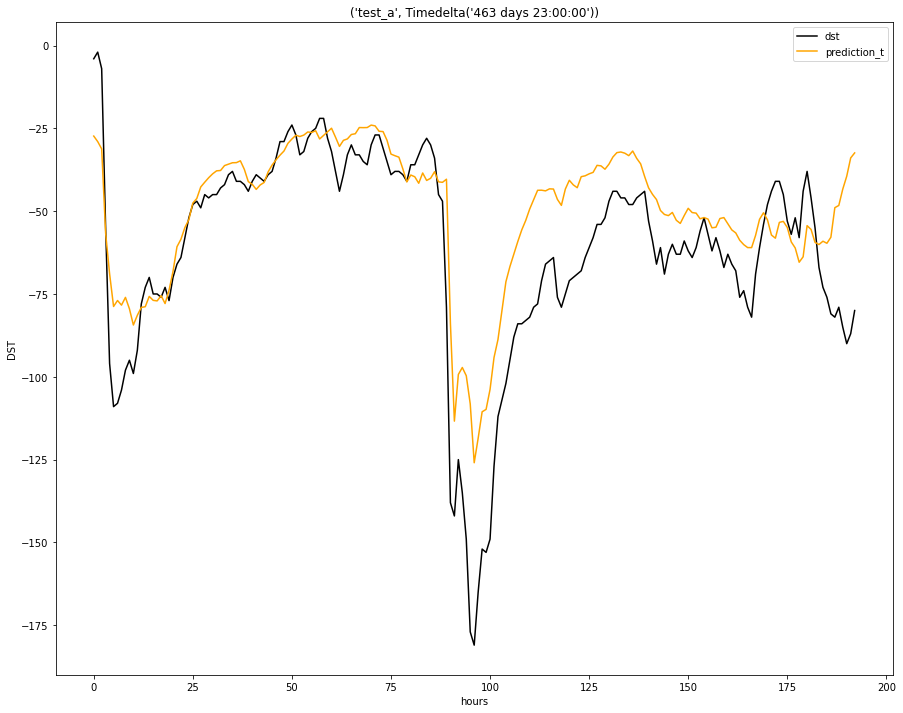

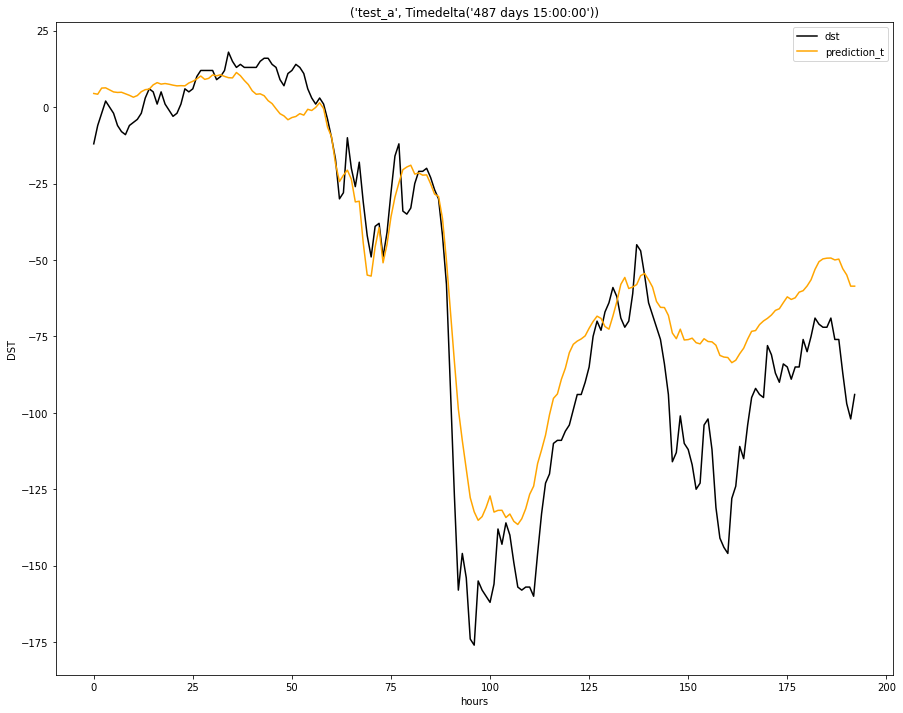

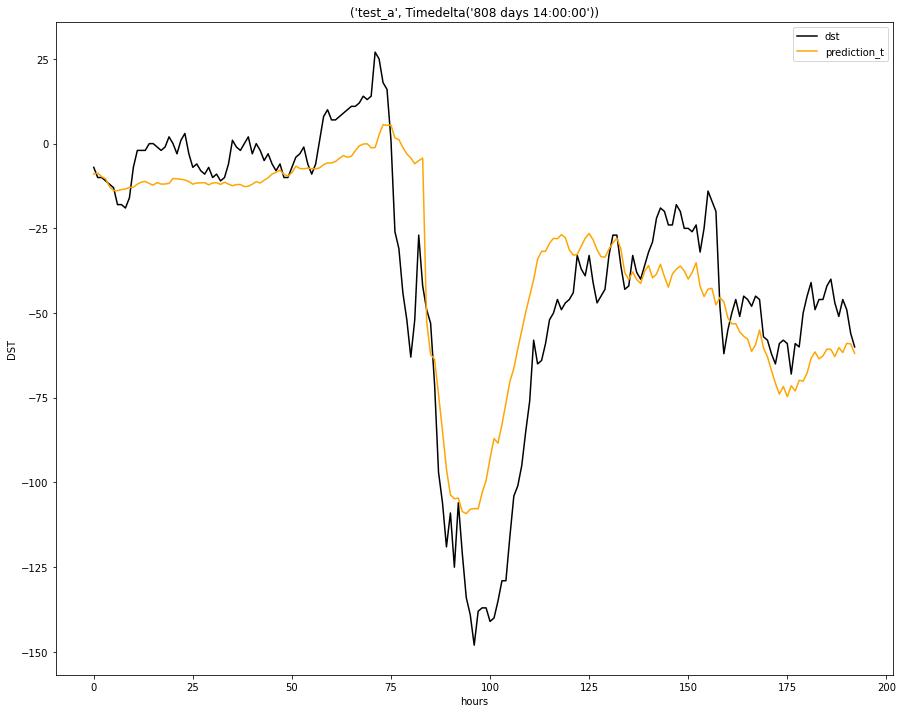

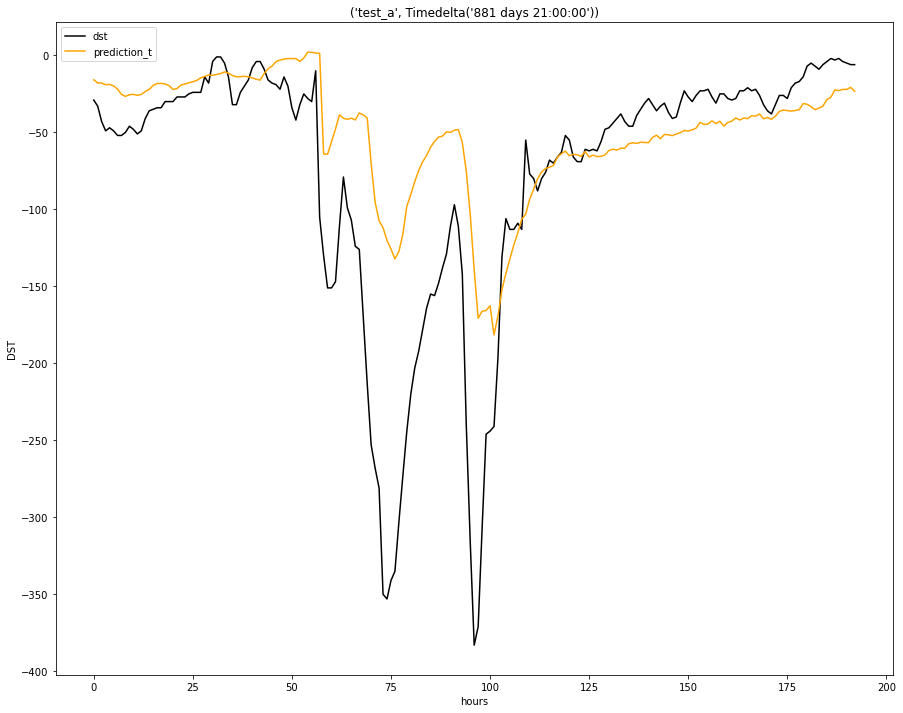

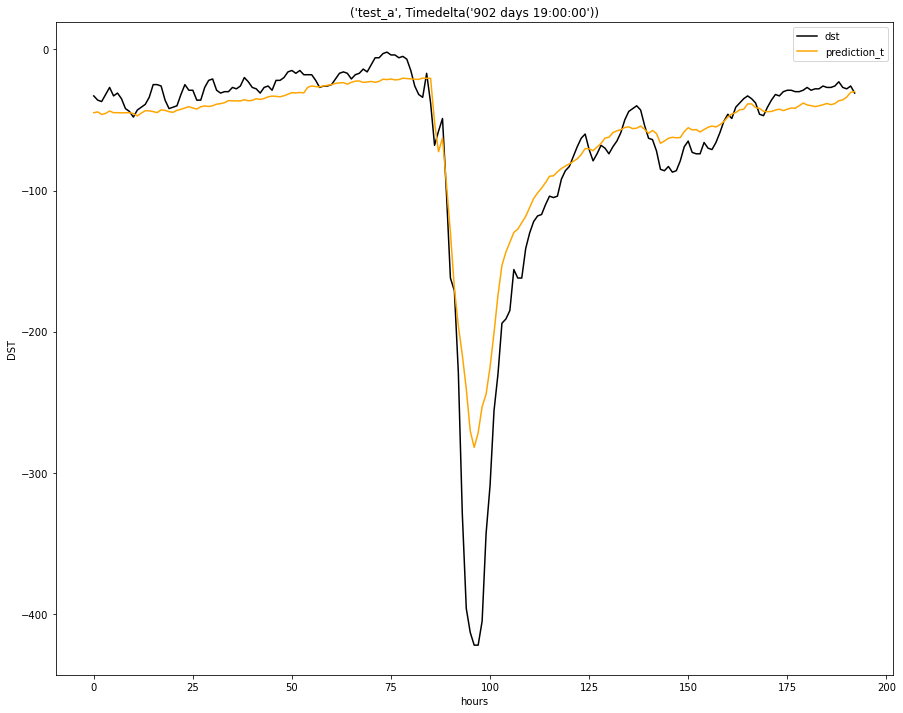

In [94]:
# plot forecast vs actual at storm events
# select events at least 7 days apart
num_events = 10
min_ind_arr = []
min_time_arr = []
labels = []
# dst
dst_test['exclude'] = False
for i in range(num_events):
    min_ind = dst_test.loc[~dst_test['exclude'], 'dst'].idxmin()
    min_time = dst_test.loc[min_ind, ['timedelta', 'period']]
    min_time_arr.append(min_time)
    t, p = min_time['timedelta'], min_time['period']
    min_ind_arr.append(min_ind)
    labels.append(f"{min_time['period'], min_time['timedelta']}")
    dst_test['exclude'] = dst_test['exclude'] | (((dst_test['timedelta'] - t).dt.total_seconds().abs() <= 7 * 24 * 3600) & (dst_test['period'] == p))

# sort by period and timedelta
sort_ind = list(range(num_events))
sort_ind = sorted(sort_ind, key=lambda x: (min_time_arr[x]['period'], min_time_arr[x]['timedelta']))
min_ind_arr = [min_ind_arr[i] for i in sort_ind]
labels = [labels[i] for i in sort_ind]


for i in range(num_events):
    # extract 96 hours before and after max
    ind = min_ind_arr[i]
    # centre on min within 96 * 2 hour window
    new_min = dst_test.loc[ind - 96: ind + 96, 'dst'].idxmin()
    df = dst_test.loc[new_min - 96: new_min + 96].copy()
    plt.figure(figsize=(15, 12))
    plt.plot(df["dst"].values, c="black")
    plt.plot(df["prediction_t"].values, c="orange")
    plt.legend(["dst", "prediction_t"])
    plt.title(labels[i])
    plt.xlabel("hours")
    plt.ylabel("DST")